In [42]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
import matplotlib.pyplot as plt
import io
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
def plot_accuracy_epoch(epochs,metric1,metric2):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, metric1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(epochs, metric2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training and Validation set losses')
    plt.show()

def plot_zoom(from_epoch,metric1,metric2):
    epochs_zoom = epochs[from_epoch:]
    metric1_zoom = metric1[from_epoch:]
    metric2_zoom = metric2[from_epoch:]

    plot_accuracy_epoch(epochs_zoom,metric1_zoom,metric2_zoom)  

seed=12

In [3]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [4]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [5]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [6]:
train_features = train_data.iloc[:, 1:]
train_label = train_data.iloc[:, 0]

train_features=train_features.astype('float32')
X_test=test_data.astype('float32')
train_features/=255
X_test/=255

X_train, X_cv, y_train, y_cv = train_test_split(train_features, train_label, test_size = 0.2, random_state = seed)

num_digits = 10
y_train = keras.utils.to_categorical(y_train, num_digits)
y_cv = keras.utils.to_categorical(y_cv, num_digits)

In [7]:
batch_size=128

model_nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=[train_features.shape[1]], activation="relu"), 
    tf.keras.layers.Dense(128, activation="relu"), 
    tf.keras.layers.Dense(128, activation="relu"), 
    tf.keras.layers.Dense(128, activation="relu"), 
    tf.keras.layers.Dense(num_digits, activation="softmax")
])

model_nn.summary()
model_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 151,306
Trainable params: 151,306
Non-trainable params: 0
_________________________________________________________________


In [8]:
history_nn = model_nn.fit(X_train,y_train,batch_size = batch_size,epochs = 100,verbose = 1,validation_data=(X_cv, y_cv))

Epoch 1/100
263/263 [==============================] - 2s 7ms/step - loss: 0.4073 - accuracy: 0.8787 - val_loss: 0.2068 - val_accuracy: 0.9371
Epoch 2/100
263/263 [==============================] - 1s 5ms/step - loss: 0.1450 - accuracy: 0.9560 - val_loss: 0.1369 - val_accuracy: 0.9588
Epoch 3/100
263/263 [==============================] - 1s 5ms/step - loss: 0.0981 - accuracy: 0.9694 - val_loss: 0.1145 - val_accuracy: 0.9667
Epoch 4/100
263/263 [==============================] - 1s 5ms/step - loss: 0.0712 - accuracy: 0.9782 - val_loss: 0.1009 - val_accuracy: 0.9701
Epoch 5/100
263/263 [==============================] - 1s 5ms/step - loss: 0.0588 - accuracy: 0.9815 - val_loss: 0.1236 - val_accuracy: 0.9658
Epoch 6/100
263/263 [==============================] - 1s 5ms/step - loss: 0.0458 - accuracy: 0.9850 - val_loss: 0.1113 - val_accuracy: 0.9700
Epoch 7/100
263/263 [==============================] - 1s 5ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.1171 - val_accuracy: 0.9679

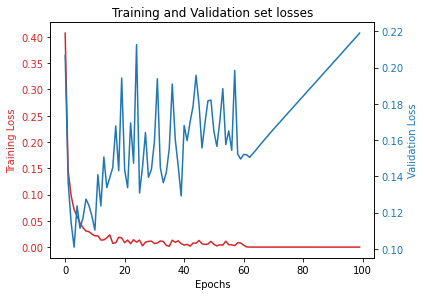

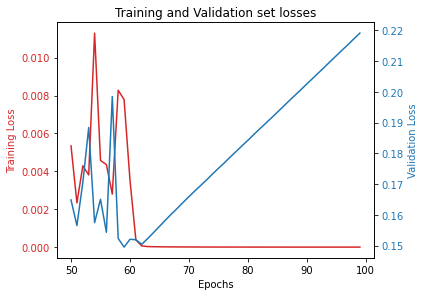

In [9]:
train_loss=history_nn.history['loss']
valid_loss=history_nn.history['val_loss']
epochs=range(len(train_loss))

plot_accuracy_epoch(epochs,train_loss,valid_loss)
plot_zoom(50,train_loss,valid_loss)

In [10]:
X_train_cnn=X_train.values.reshape(-1,28,28,1)
X_cv_cnn=X_cv.values.reshape(-1,28,28,1)
X_test_cnn=X_test.values.reshape(-1,28,28,1)

In [51]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, input_shape=(28,28,1), activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_digits, activation="softmax")
])

model_cnn.summary()
model_cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam() , metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.0001)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_27 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_28 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 64)        

In [54]:
history_cnn = model_cnn.fit(X_train_cnn,y_train,batch_size = batch_size,epochs = 50,verbose = 1,validation_data=(X_cv_cnn, y_cv))

Epoch 1/50
263/263 [==============================] - 4s 13ms/step - loss: 0.0354 - accuracy: 0.9895 - val_loss: 0.0396 - val_accuracy: 0.9907
Epoch 2/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0347 - accuracy: 0.9897 - val_loss: 0.0412 - val_accuracy: 0.9901
Epoch 3/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0344 - accuracy: 0.9901 - val_loss: 0.0440 - val_accuracy: 0.9902
Epoch 4/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0311 - accuracy: 0.9898 - val_loss: 0.0455 - val_accuracy: 0.9917
Epoch 5/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0317 - accuracy: 0.9897 - val_loss: 0.0440 - val_accuracy: 0.9904
Epoch 6/50
263/263 [==============================] - 3s 13ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.0431 - val_accuracy: 0.9911
Epoch 7/50
263/263 [==============================] - 3s 12ms/step - loss: 0.0343 - accuracy: 0.9899 - val_loss: 0.0422 - val_accuracy: 0.9905

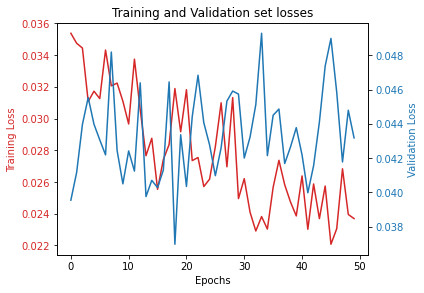

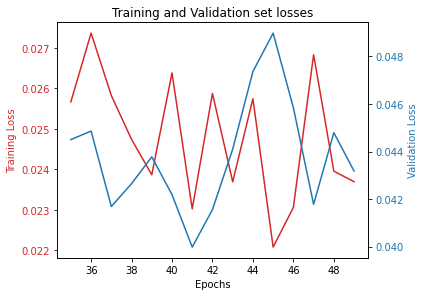

In [55]:
train_loss=history_cnn.history['loss']
valid_loss=history_cnn.history['val_loss']
epochs=range(len(train_loss))

plot_accuracy_epoch(epochs,train_loss,valid_loss)
plot_zoom(35,train_loss,valid_loss)

In [58]:
datagen = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1,width_shift_range = 0.1, height_shift_range = 0.1)
datagen.fit(X_train_cnn)
train_batches = datagen.flow(X_train_cnn, y_train, batch_size = batch_size)

In [59]:
history_cnn_aug = model_cnn.fit_generator(train_batches,epochs = 20,verbose = 1,validation_data=(X_cv_cnn, y_cv))

Epoch 1/20
263/263 [==============================] - 13s 50ms/step - loss: 0.2859 - accuracy: 0.9221 - val_loss: 0.0372 - val_accuracy: 0.9895
Epoch 2/20
263/263 [==============================] - 13s 50ms/step - loss: 0.2146 - accuracy: 0.9393 - val_loss: 0.0416 - val_accuracy: 0.9894
Epoch 3/20
263/263 [==============================] - 14s 54ms/step - loss: 0.1882 - accuracy: 0.9454 - val_loss: 0.0362 - val_accuracy: 0.9907
Epoch 4/20
263/263 [==============================] - 13s 51ms/step - loss: 0.1804 - accuracy: 0.9477 - val_loss: 0.0419 - val_accuracy: 0.9893
Epoch 5/20
263/263 [==============================] - 14s 51ms/step - loss: 0.1684 - accuracy: 0.9502 - val_loss: 0.0361 - val_accuracy: 0.9899
Epoch 6/20
263/263 [==============================] - 13s 50ms/step - loss: 0.1568 - accuracy: 0.9540 - val_loss: 0.0343 - val_accuracy: 0.9899
Epoch 7/20
263/263 [==============================] - 13s 51ms/step - loss: 0.1493 - accuracy: 0.9562 - val_loss: 0.0319 - val_accuracy:

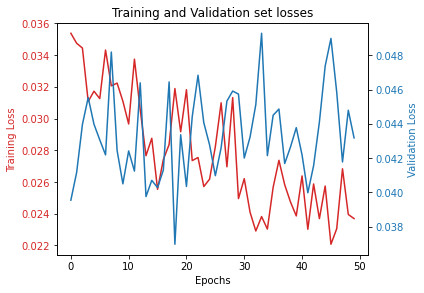

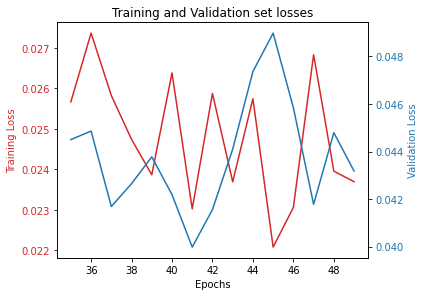

In [60]:
train_loss=history_cnn.history['loss']
valid_loss=history_cnn.history['val_loss']
epochs=range(len(train_loss))

plot_accuracy_epoch(epochs,train_loss,valid_loss)
plot_zoom(35,train_loss,valid_loss)

In [57]:
final_model=model_cnn
test_feature=X_test_cnn

test_pred = pd.DataFrame(final_model.predict(test_feature, batch_size=128))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.to_csv('mnist_submission.csv', index = False)